In [70]:
import cv2
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.ndimage

In [164]:
def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv2.resize(image, dim, interpolation = inter)

    # return the resized image
    return resized

In [188]:
# read image
img = cv2.imread("infrared.bmp")
# img = cv2.imread("../test.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = np.float64(gray)
print(f"gray: {gray.shape}")

gray: (234, 305)


x: 119, y: 150


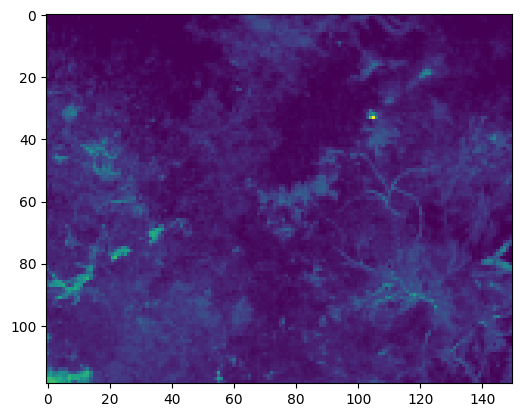

In [175]:
gray = image_resize(gray, width=150)
xsize, ysize = gray.shape
print(f"x: {xsize}, y: {ysize}")

plt.imshow(gray)
plt.show()

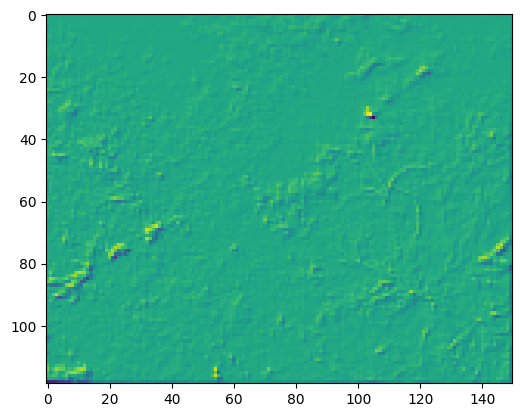

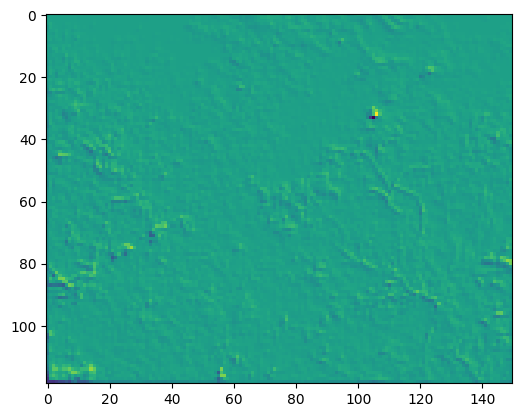

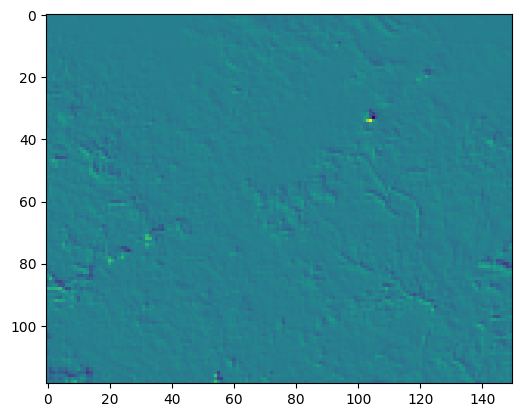

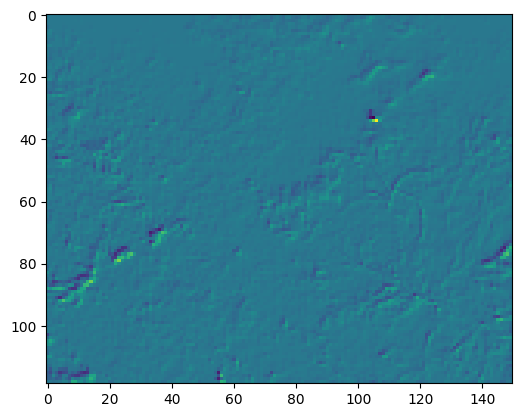

In [176]:
Gradient_Img1 = np.zeros_like(gray)
Gradient_Img2 = np.zeros_like(gray)
Gradient_Img3 = np.zeros_like(gray)
Gradient_Img4 = np.zeros_like(gray)
Gmap = np.zeros_like(gray)
Imap = np.zeros_like(gray)


# gray_padded = cv2.copyMakeBorder(gray, 1, 1, 1, 1, cv2.BORDER_REPLICATE)
# G315 = imfilter(I,[ 0,0,0; 0,-1,0; 0,0,1],'replicate');
# G315 = cv2.filter2D(gray_padded, -1, np.array([[0,0,0],[0,-1,0],[0,0,1]]))
G315 = scipy.ndimage.correlate(gray, np.array([[0,0,0],[0,-1,0],[0,0,1]]), mode='constant')#.transpose()
# G225 = imfilter(I,[0,0,0; 0,-1,0; 1,0,0],'replicate');
# G225 = cv2.filter2D(gray_padded, -1, np.array([[0,0,0],[0,-1,0],[1,0,0]]))
G225 = scipy.ndimage.correlate(gray, np.array([[0,0,0],[0,-1,0],[1,0,0]]), mode='constant')#.transpose()
# G45=imfilter(I,[0,0,1;0,-1,0; 0,0,0],'replicate');
# G45 = cv2.filter2D(gray_padded, -1, np.array([[0,0,1],[0,-1,0],[0,0,0]]))
G45 = scipy.ndimage.correlate(gray, np.array([[0,0,1],[0,-1,0],[0,0,0]]), mode='nearest')#.transpose()
# G135=imfilter(I,[1,0,0; 0,-1,0; 0,0,0],'replicate');
# G135 = cv2.filter2D(gray_padded, -1, np.array([[1,0,0],[0,-1,0],[0,0,0]]))
G135 = scipy.ndimage.correlate(gray, np.array([[1,0,0],[0,-1,0],[0,0,0]]), mode='nearest')#.transpose()

# plt.imshow(gray_padded)
# plt.show()
plt.imshow(G315)
plt.show()
plt.imshow(G225)
plt.show()
plt.imshow(G45)
plt.show()
plt.imshow(G135)
plt.show()

iterating from 10 to 109


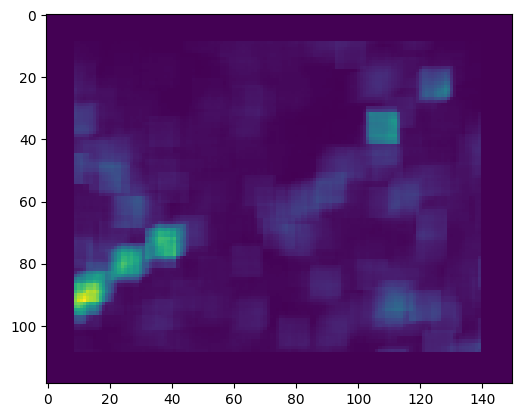

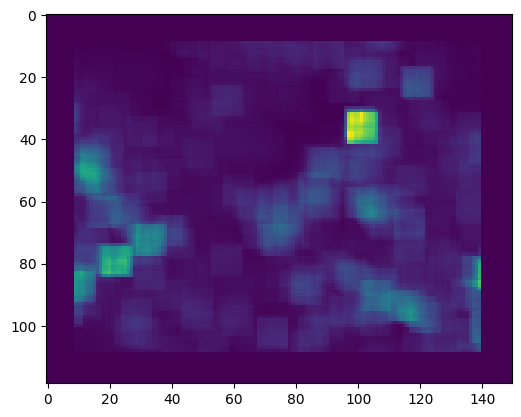

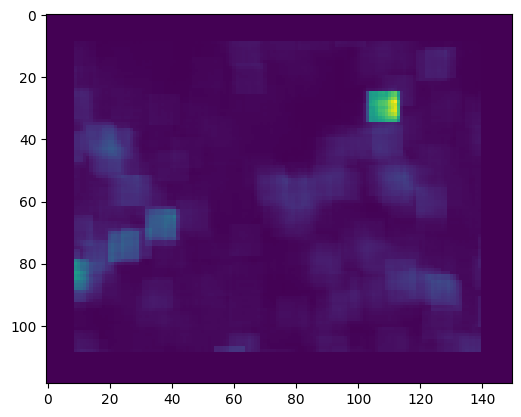

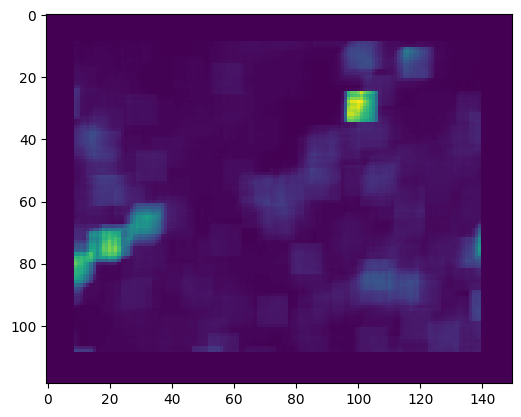

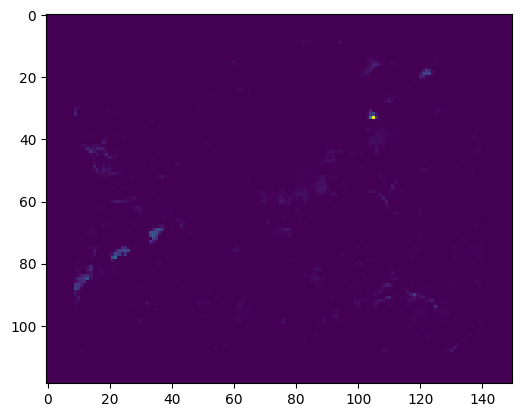

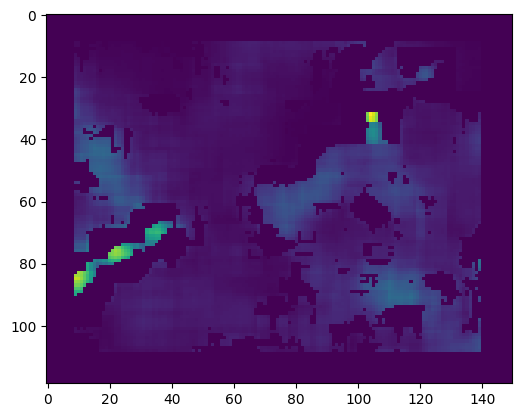

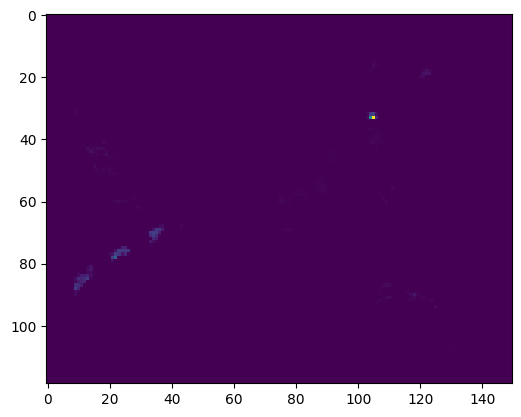

In [177]:
# parameters
k=0.2;
N=19;


mapscale = int((N-1)/2)
scale = mapscale+1

print(f"iterating from {scale} to {xsize-scale}")
for i in range(scale-1, xsize-scale):
    for j in range(scale-1, ysize-scale):

        C0 = G315[i-mapscale:i+1,j-mapscale:j+1]
        x0 = C0[C0>0]
        Gradient_Img1[i,j] = np.sum(x0**2)/(x0.size+0.001)

        C1 = G225[i-mapscale:i+1,j:j+mapscale+1]
        x1 = C1[C1>0]
        Gradient_Img2[i,j] = np.sum(x1**2)/(x1.size+0.001)

        C2 = G45[i:i+mapscale+1,j-mapscale:j+1]
        x2 = C2[C2>0]
        Gradient_Img3[i,j] = np.sum(x2**2)/(x2.size+0.001)

        C3 = G135[i:i+mapscale+1,j:j+mapscale+1]
        x3 = C3[C3>0]
        Gradient_Img4[i,j] = np.sum(x3**2)/(x3.size+0.001)

        concat = np.stack((Gradient_Img1[i,j],
                           Gradient_Img2[i,j],
                           Gradient_Img3[i,j],
                           Gradient_Img4[i,j]))

        dnmax = np.amax(concat)
        dnmin = np.amin(concat)

        # print(f": dmax: {dnmax}, dmin: {dnmin}")

        if (dnmin/dnmax) < k:
            Gmap[i,j] = 0
        else:
            Gmap[i,j] = np.sum(concat)

        # print(f"sum: {np.sum(concat)}, gmap: {Gmap[i,j]}")


        K_temp = (gray[i,j] - np.mean(gray[i-mapscale:i+mapscale+1,j-mapscale:j+mapscale+1]))**2;
        # K_temp = (gray[i,j]- np.sum(gray[i-mapscale:i+mapscale,j-mapscale:j+mapscale]))/(1-gray[i-mapscale:i+mapscale,j-mapscale:j+mapscale].size)
        # print(f"center: {gray[i,j]}")
        # print(f"local intensity: {gray[i-mapscale:i+mapscale,j-mapscale:j+mapscale]}, shape: {gray[i-mapscale:i+mapscale,j-mapscale:j+mapscale].size}")
        # print(f"ktemp: {K_temp}")
        # print(f"gray: {gray[i,j]}")

        if K_temp > 0:
            # Imap[i,j] = gray[i,j] - K_temp
            Imap[i,j] = K_temp

    #     break
    # break

plt.imshow(Gradient_Img1)
plt.show()
plt.imshow(Gradient_Img2)
plt.show()
plt.imshow(Gradient_Img3)
plt.show()
plt.imshow(Gradient_Img4)
plt.show()

plt.imshow(Imap)
plt.show()
plt.imshow(Gmap)
plt.show()

Gmap = Gmap * Imap
LIGmap = cv2.normalize(Gmap, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
# final = Gmap.astype("float32")/255
plt.imshow(LIGmap)
plt.show()

In [178]:
def contour_area(contours):
    # create an empty list
    cnt_area = []

    # loop through all the contours
    for i in range(0,len(contours),1):
        # for each contour, use OpenCV to calculate the area of the contour
        cnt_area.append(cv2.contourArea(contours[i]))
 
    # Sort our list of contour areas in descending order
    list.sort(cnt_area, reverse=True)
    return cnt_area

def draw_bounding_box(contours, image, number_of_boxes=1):
    # Call our function to get the list of contour areas
    cnt_area = contour_area(contours)
 
    # Loop through each contour of our image
    for i in range(0,len(contours),1):
        cnt = contours[i]
 
        # Only draw the the largest number of boxes
        if (cv2.contourArea(cnt) > cnt_area[number_of_boxes]):

            # Use OpenCV boundingRect function to get the details of the contour
            x,y,w,h = cv2.boundingRect(cnt)

            # Draw the bounding box
            image=cv2.rectangle(image,(x,y),(x+w,y+h),(0,0,255),2)
 
    return image

count: [[[105  33]]]


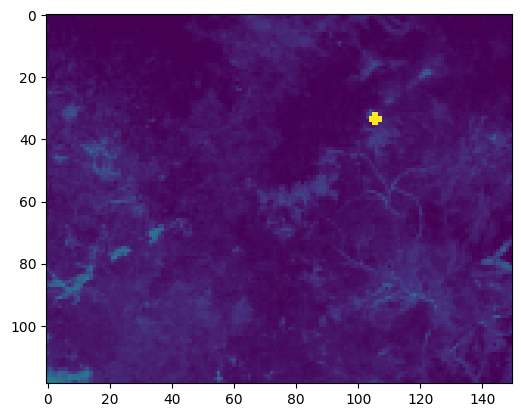

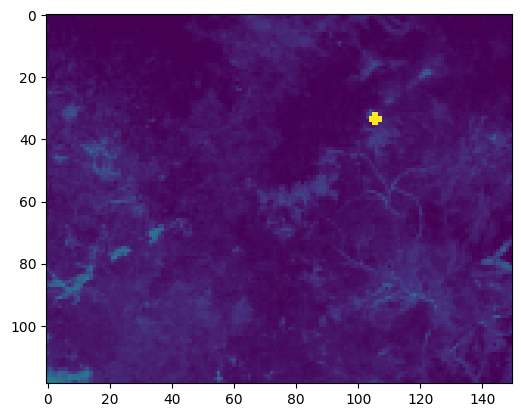

In [187]:

# coords = cv2.findNonZero(LIGmap)
# x,y,w,h = cv2.boundingRect(coords)
# cv2.rectangle(gray, (x,y), (x+w,y+h), (0,255,0), 2)

LIGmap = LIGmap.astype(np.uint8)
count, _ = cv2.findContours(LIGmap, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
cnt = count[0]
print(f"count: {cnt}")

x,y,w,h = cv2.boundingRect(cnt)
result = cv2.drawContours(gray, [cnt],0,(255,255,255),2)

result2 = cv2.rectangle(gray,(x,y),(x+w,y+h),(255,255,0),2)

plt.imshow(result)
plt.show()

plt.imshow(result2)
plt.show()